In [ ]:
!pip install optuna

In [ ]:
!pip install shap

In [22]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import shap
import optuna
from optuna.visualization import plot_slice, plot_param_importances

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from utils import model

from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
## load the training and validation data
train_features = pd.read_csv("Data/ProcessedData/train_features.csv")
train_labels = pd.read_csv("Data/ProcessedData/train_labels.csv")
validation_features = pd.read_csv("Data/ProcessedData/validation_features.csv")
validation_labels = pd.read_csv("Data/ProcessedData/validation_labels.csv")

In [7]:
## tranform target value
train_labels = np.log1p(train_labels)

#### LightGBM

In [28]:
### LightGBM
import importlib
importlib.reload(model)

best_lgb, lgb_parameters, study = model.lgb_model(train_features, train_labels, validation_features, validation_labels, seed=42, n_trials=200)

[I 2023-10-31 02:02:23,685] A new study created in memory with name: LightGBM Regression
[I 2023-10-31 02:02:24,273] Trial 0 finished with value: 1.2639025207167882 and parameters: {'num_iterations': 80, 'learning_rate': 0.085, 'num_leaves': 36, 'max_depth': 5, 'lambda_l1': 0.03, 'min_data_in_leaf': 20, 'bagging_fraction': 0.87, 'feature_fraction_bynode': 0.77}. Best is trial 0 with value: 1.2639025207167882.
[I 2023-10-31 02:02:24,401] Trial 1 finished with value: 1.0484051173712539 and parameters: {'num_iterations': 70, 'learning_rate': 0.085, 'num_leaves': 18, 'max_depth': 5, 'lambda_l1': 0.08, 'min_data_in_leaf': 85, 'bagging_fraction': 0.71, 'feature_fraction_bynode': 0.71}. Best is trial 1 with value: 1.0484051173712539.
[I 2023-10-31 02:02:24,497] Trial 2 finished with value: 1.0378313932567533 and parameters: {'num_iterations': 50, 'learning_rate': 0.045, 'num_leaves': 26, 'max_depth': 4, 'lambda_l1': 0.02, 'min_data_in_leaf': 95, 'bagging_fraction': 0.83, 'feature_fraction_byn

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.09999999999999999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.8099999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8099999999999999
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.09999999999999999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.8099999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8099999999999999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

##### Hyperparameter Tuning

In [30]:
plot_slice(study)

In [31]:
plot_param_importances(study)

##### Feature Importance Analysis

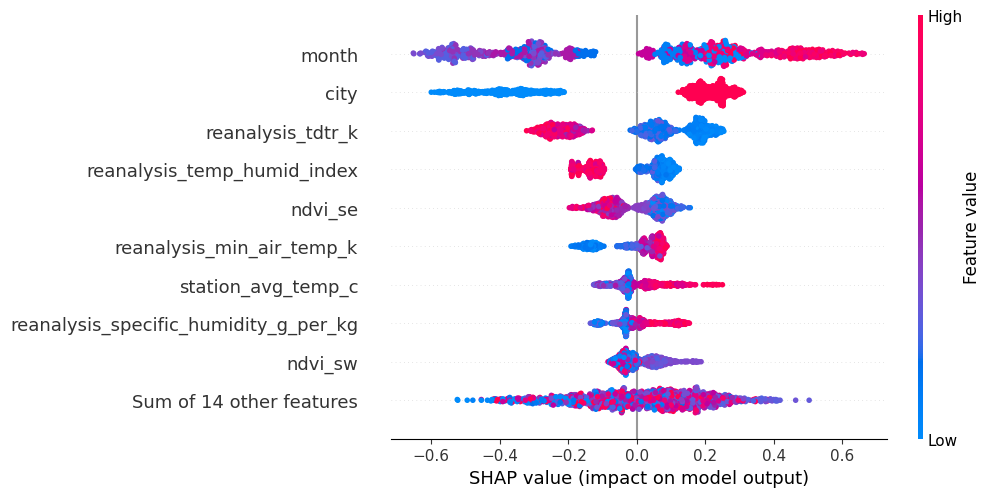

In [32]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_lgb)
shap_values = explainer(train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

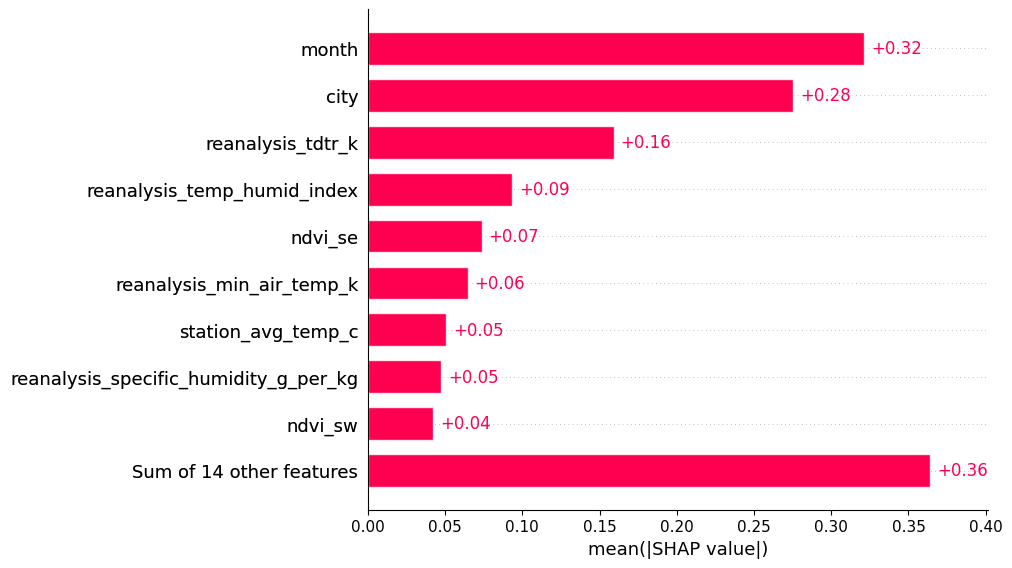

In [33]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

In [34]:
## save best parameters
with open('Outputs/lgb_params.pickle', 'wb') as handle:
    pickle.dump(lgb_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### XGBoost

In [16]:
## XGBoost
import importlib
importlib.reload(model)

best_xgb, xgb_parameters, study = model.xgb_model(train_features, train_labels, validation_features, validation_labels, seed=42, n_trials=150)

[I 2023-10-31 01:17:43,889] A new study created in memory with name: XGBoost
[I 2023-10-31 01:17:44,009] Trial 0 finished with value: 1.3863998531998054 and parameters: {'n_estimators': 140, 'learning_rate': 0.085, 'max_depth': 6, 'subsample': 0.7, 'min_child_weight': 10, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.1, 'reg_alpha': 0.2}. Best is trial 0 with value: 1.3863998531998054.
[I 2023-10-31 01:17:44,129] Trial 1 finished with value: 1.3977459347176824 and parameters: {'n_estimators': 70, 'learning_rate': 0.045, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 10, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.2, 'reg_alpha': 0.05}. Best is trial 0 with value: 1.3863998531998054.
[I 2023-10-31 01:17:44,223] Trial 2 finished with value: 1.4438208610144052 and parameters: {'n_estimators': 60, 'learning_rate': 0.055, 'max_depth': 3, 'subsample': 0.7999999999999999, 'min_child_weight': 5, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.1, 'reg_alpha': 0.05}. Best is tria



Final MAE for validation set is 12.547945205479452


##### Hyperparameter Tuning

In [23]:
plot_slice(study)

In [24]:
plot_param_importances(study)

##### Feature Importance Analysis

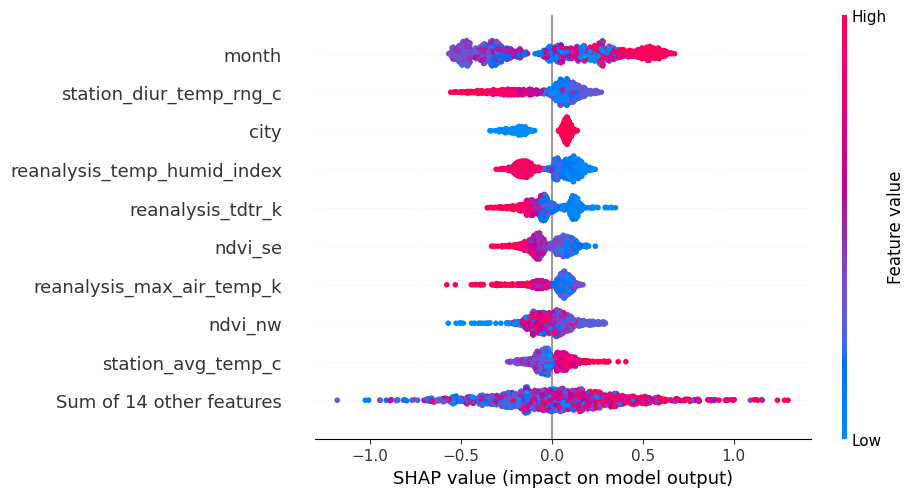

In [25]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_xgb)
shap_values = explainer(train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

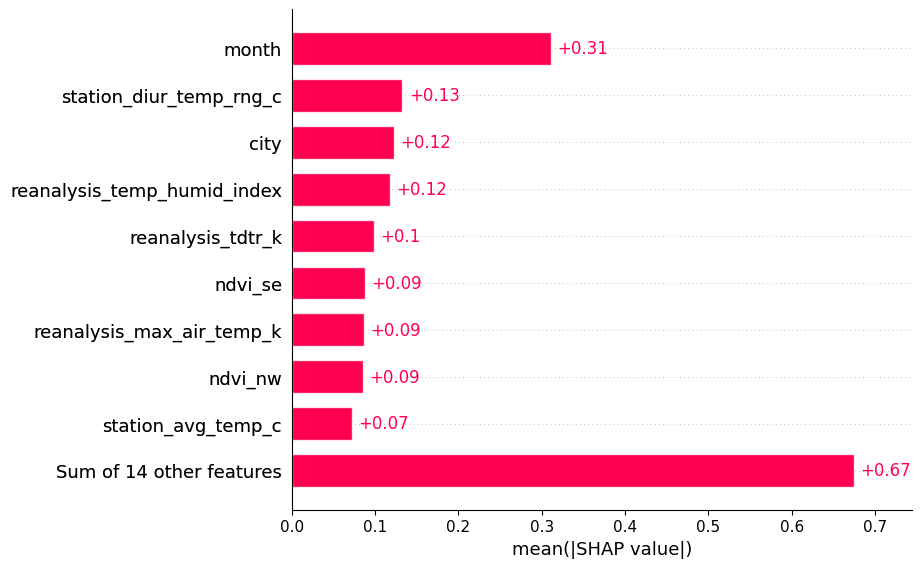

In [26]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

In [29]:
## save best parameters
with open('Outputs/xgb_params.pickle', 'wb') as handle:
    pickle.dump(xgb_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## read best parameters
with open('Outputs/xgb_params.pickle', 'rb') as handle:
    xgb_parameters = pickle.load(handle)

#### Submission

In [37]:
from utils import feature_engineer

## skewed features
right_skew_col = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
left_skew_col = ['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'station_min_temp_c']

test = pd.read_csv("Data/ProcessedData/dengue_features_test.csv")
test_features = pd.read_csv("Data/ProcessedData/dengue_features_test.csv")
test_features['month'] = pd.to_datetime(test_features['week_start_date']).dt.month
test_features = feature_engineer.feature_engineer_pipeline(test_features, right_skew_col=right_skew_col, left_skew_col=left_skew_col)

In [38]:
test['total_cases'] = np.expm1(best_lgb.predict(test_features)).astype(int).clip(0)
test[['city','year','weekofyear','total_cases']].to_csv('submission_lgb.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08
[LightGBM] [Warning] bagging_fraction is set=0.83, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83
